# GUI

In [22]:
import matplotlib.pyplot as plt
import tkinter as tk
from PIL import ImageTk, Image, ImageDraw
import cv2 as cv
import pickle as pk
import numpy as np
from skimage.feature import hog

In [26]:
def get_roi(image):
    ''' return region of interest of binary image'''   
    # find contours
    ctrs, hier = cv.findContours(image.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Get rectangle
    x, y, w, h = cv.boundingRect(ctrs[0]) #(x, y, width, height)
    # copy segmented image
    im_crop = image[y-5:y+h+5,x-5:x+w+5,]
    return im_crop

def get_roi_all(image): 
    ''' find objects in image, return vector of segmented images and respective rectangles'''
    # find contours
    ctrs, hier = cv.findContours(image.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # find rectangles
    rects = [cv.boundingRect(ctr) for ctr in ctrs]
    #copy each object to image vector
    im_vec = [image[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] for rect in rects]
    return im_vec, rects

def draw_named_rect(image, rectangle, text):
    '''draw rectangle and name it'''
    rect = rectangle
    img = image
    cv.rectangle(img, (rect[0],rect[1]),(rect[0]+rect[2],rect[1]+rect[3]), 255, 1)
    cv.putText(img, text,(rect[0],rect[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.9,255, 1)
    return img
    
        
    
    
    
def adjust_img(image, width, height):
    ''' apply lowpass filter to image and resize to (height, width)'''
    image = cv.GaussianBlur(image,(5,5),1)
    image = cv.resize(image, dsize = (height,width),interpolation=cv.INTER_AREA)
    plt.imshow(image)
    #image_vec = image.reshape(1,-1)
    image_vec = hog(image, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1))
    print(image_vec.shape)
    return image_vec
    

In [29]:
class Gui:
    ''' - Display a GUI to allow classification of handwritten characters
        - Use Gui.start() to run GUI, respective classifier and target type as argument needed
    '''
    
    #window + canvas to draw on
    im_w, im_h = (600,600)
    # invisible image for copying canvas
    __img = None 
    __draw_Obj = None
    __thicknes = None
    #canvas
    canvas = None
    #text windows
    textPred = None
    entryAcc = None

    # attributes for calculating accuracy
    __mean = 0
    __tries = 0
    # Classifier
    __clf = None
    #Target Type: letters, digits
    target_type = None

    @classmethod
    def __draw(cls, event):
        #draw white line on black background
        offs = cls.__thicknes
        #draws on the canvas and on an invisible image that contains the same drawing
        cls.canvas.create_oval((event.x-offs),(event.y-offs), event.x+offs, event.y+offs, fill='white', outline ='white')
        cls.__draw_Obj.ellipse([(event.x-offs),(event.y-offs), event.x+offs, event.y+offs], fill='white')

    @classmethod
    def __del_img(cls):

        cls.canvas.delete('all')
        #delete img by reinitializing it
        cls.__img = Image.new('L',(cls.im_w, cls.im_h))
        cls.__draw_Obj = ImageDraw.Draw(cls.__img)
        #delete prediction output
        cls.textPred.delete(1.0,tk.END)

    @classmethod
    def __predict(cls):
        '''predict digit,and display classification
        '''
        cls.__img.save('img.png')
        im = cv.imread('img.png',cv.IMREAD_GRAYSCALE)
        # find the character in image
        images_roi, rects = get_roi_all(im)
        
        for idx, rect in enumerate(rects):
            # fit the image to data set
            im_vec = adjust_img(images_roi[idx], 28 ,28)
            pred  = cls.__clf.predict(np.array([im_vec], 'float64'))
            # set character depending on target_type
            if cls.target_type == 'digits' or cls.target_type == 'all':
                #either classes from 0 to 9 (digits) or 0 to 61 (all)
                if pred<= 9:
                    offset = 48 # 0--> 48
                elif pred <36:
                    offset = 55 # A --> 65
                else:
                    offset = 60# a --> 97
            elif cls.target_type == 'letters':
                #classes from 1 to 26 (upper + lower case in one class)
                offset = 64 # A --> 65
            else:
                raise ValueError('target_type must be "digits", "all" or "letters"')
            #draw classification
            im = draw_named_rect(im, rect, chr(pred[0]+offset))
        cv.imshow('s', im)
        cv.waitKey(0)
        cv.destroyAllWindows()
        cls.textPred.delete(1.0,tk.END)
        cls.textPred.insert(tk.INSERT,f'class: {pred[0]}\nascii: '+chr(offset + pred[0]))

    #detecting the mean of user digits in percent   
    @classmethod
    def __yes(cls):
        '''Correct classification, adjust accuracy'''
        cls.__tries +=1
        cls.__mean = cls.__mean*(cls.__tries-1)/cls.__tries + 1/cls.__tries
        cls.entryAcc.delete(0,tk.END)
        cls.entryAcc.insert(tk.INSERT,str(round(cls.__mean*100,1))+'%')
        cls.__del_img()

    @classmethod
    def __no(cls):
        '''wrong classification, adjust accuracy'''
        cls.__tries +=1
        cls.__mean = cls.__mean*(cls.__tries-1)/cls.__tries
        cls.entryAcc.delete(0,tk.END)
        cls.entryAcc.insert(tk.INSERT,str(round(cls.__mean*100,1))+'%')
        cls.__del_img()
    
    @classmethod
    def __inc_thickness(cls):
        if  cls.__thicknes < 11:
            cls.__thicknes+=1
    
    @classmethod
    def __dec_thickness(cls):
        if  cls.__thicknes > 1:
            cls.__thicknes-=1
    

    @classmethod
    def __key_yes_no(cls, event):
        key = event.char
        if key == 'n' or key == 'N':
            cls.__no()
        if key == 'y' or key == 'Y':
            cls.__yes()
        if key == 'r' or key == 'R':
            cls.__reset()
        if key == '+':
            cls.__inc_thickness()
        if key == '-':
            cls.__dec_thickness()
            

    @classmethod
    def __reset(cls):
        '''reset calculation of accuracy'''
        cls.__mean = 0
        cls.__tries = 0
        cls.entryAcc.delete(0,tk.END)


    @classmethod
    def start(cls, clf, target_type: str):
        if not isinstance(target_type, str):
            raise TypeError('target_type must be of type str')
        # set classifier and target type
        cls.__clf = clf
        cls.target_type = target_type
        
        #initialize image
        cls.__img = Image.new('L',(cls.im_w, cls.im_h))
        cls.__draw_Obj = ImageDraw.Draw(cls.__img)
        cls.__thicknes = 5
        m = tk.Tk()
        m.minsize(300,300)

        # canvas to draw on
        cls.canvas = tk.Canvas(m, width=cls.im_w, height=cls.im_h, bg = 'black')
        cls.canvas.grid(row = 0, column = 1,columnspan=5 ,rowspan = 5)
        cls.canvas.x_old = None
        cls.canvas.y_old = None
        cls.canvas.x_new = None
        cls.canvas.y_new = None
        cls.canvas.winfo_height
        m.bind('<B1-Motion>', cls.__draw)

        #Buttons
        buttonDelete = tk.Button(m, text='delete',width=10,height = 1,command=cls.__del_img)
        buttonDelete.grid(row = 0, column = 0)

        buttonPred = tk.Button(m, text='predict',width=10,height = 1,command=cls.__predict)
        buttonPred.grid(row = 1, column = 0)
        labelPred =tk.Label(m, text='Prediction:')
        labelPred.grid(row = 2, column = 0)
        cls.textPred = tk.Text(m,width = 10, height = 2, font = 15)
        cls.textPred.grid(row = 3, column = 0)

        buttonYes = tk.Button(m, text='Yes [y]',width=10,height = 1,bg ='green', command=cls.__yes)
        buttonYes.grid(row = 4, column = 0)
        buttonNo = tk.Button(m, text='No [n]',width=10,height = 1,bg ='red', command=cls.__no)
        buttonNo.grid(row = 5, column = 0)

        #bind 'n' and 'y' keyboard
        m.bind('<Key>', cls.__key_yes_no)


        labelAcc =tk.Label(m, text='Accuracy:')
        labelAcc.grid(row = 6, column = 0)
        cls.entryAcc = tk.Entry(m,width = 10, font = 15)
        cls.entryAcc.grid(row = 7, column = 0)
        buttonReset = tk.Button(m, text='Reset % [r]',width=10,height = 1,bg ='grey', command=cls.__reset)
        buttonReset.grid(row = 7, column = 1)


        m.mainloop()
        

(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


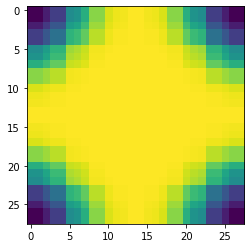

In [30]:
with open('dig_MLP_clf_hog.pickle', 'rb') as f:
    dig_MLP_clf_hog = pk.load(f)

Gui.start(dig_MLP_clf_hog, 'digits')